# Notebook #1: Designing and evaluating a recommendation algorithm

In this notebook, we become familiar with the Python recommendation toolbox, in the simplest possible way. First, we setup the working environment in GDrive. Then, we go through the experimental pipeline, by:
- loading the Movielens 1M dataset;
- performing a train-test splitting;
- creating a pointwise / pairwise / random / mostpop recommendation object;
- training the model (if applicable);
- computing the user-item relevance matrix;
- calculating some of the recommendation metrics (e.g., NDCG, Item Coverage, Diversity, Novelty).

The trained models, together with the partial computation we will save (e.g., user-item relevance matrix or metrics), will be the starting point of the investigation and the treatment covered by the other Jupyter notebooks.

**IMPORTANT**: Please go the "Runtime" option in the top menu, then click on "Change runtime" and select "GPU".

## Setup the working environment for this notebook

- Python 3.6
- Package Requirements: matplotlib, numpy, pandas, scikit-learn, scipy, tensorflow-gpu==2.0
- Storage requirements: around 1GB

This step serves to mount GDrive storage within this Jupyter notebook. The command will request us to give access permissions to this notebook, so that we will be able to clone the project repository when we desire. Please follow the prompted instructions.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

We will clone the project repository in our My Drive folder. If you wish to change the target folder, please modify the command below.

In [ ]:
# %cd /content/gdrive/My Drive/

In [ ]:
# ! git clone https://github.com/biasinrecsys/umap2020.git
! git clone https://github.com/rahmanidashti/FairnessRecSysTutorial.git

Cloning into 'FairnessRecSysTutorial'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 138 (delta 29), reused 129 (delta 20), pack-reused 0
Receiving objects: 100% (138/138), 10.50 MiB | 19.03 MiB/s, done.
Resolving deltas: 100% (29/29), done.


We will move to the project folder in order to install the required packages.

In [ ]:
%cd FairnessRecSysTutorial/

/content/FairnessRecSysTutorial


In [ ]:
! ls

data  docs  helpers  LICENSE.md  models  notebooks  README.md  requirements.txt


In [ ]:
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 22.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0


We will configure the notebooks directory as our working directory in order to simulate a local notebook execution.

In [ ]:
%cd ./notebooks

/content/FairnessRecSysTutorial/notebooks


## Import packages

In [ ]:
import sys
import os

sys.path.append(os.path.join('..'))

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from helpers.train_test_splitter import *
from models.pointwise import PointWise
from models.pairwise import PairWise
from models.mostpop import MostPop
from models.random import Random
from helpers.utils import *

We will define the folders where we will store our pre-computed results.

In [ ]:
data_path = '../data/'

In [ ]:
!mkdir '../data/outputs'
!mkdir '../data/outputs/splits'
!mkdir '../data/outputs/instances'
!mkdir '../data/outputs/models'
!mkdir '../data/outputs/predictions'
!mkdir '../data/outputs/metrics'

## Load data

First, we will load the Movielens 1M dataset, which has been pre-arranged in order to comply with the following structure: user_id, item_id, rating, timestamp, type (label for the item category), and type_id (unique id of the item category). For the sake of tutorial easiness, we assume here that each item is randomly assigned to one of its categories in the original dataset. Our toolbox is flexible enough to integrate any other dataset in csv format that has the same structure of the pre-arranged csv shown below. No further changes are needed to experiment with other datasets.   

In [ ]:
dataset = 'ml1m'
user_field = 'user_id'
item_field = 'item_id'
rating_field = 'rating'
time_field = 'timestamp'
type_field = 'type_id'

In [ ]:
data = pd.read_csv(os.path.join(data_path, 'datasets/' + dataset + '.csv'), encoding='utf8')

In [ ]:
data.head()

,user_id,item_id,rating,timestamp,type,type_id
0,1,1193,5.0,2000-12-31 23:12:40,Drama,7
1,2,1193,5.0,2000-12-31 22:33:33,Drama,7
2,12,1193,4.0,2000-12-31 00:49:39,Drama,7
3,15,1193,4.0,2000-12-30 19:01:19,Drama,7
4,17,1193,5.0,2000-12-30 07:41:11,Drama,7


During this tutorial, we will simulate a scenario with implicit feedback.

In [ ]:
data[rating_field] = data[rating_field].apply(lambda x: 1.0)

## Split data in train and test sets

- **smode**: 'uftime' for fixed timestamp split, 'utime' for time-based split per user, 'urandom' for random split per user
- **train_ratio**: percentage of data to be included in the train set
- **min_train**: minimum number of train samples for a user to be included  
- **min_test**: minimum number of test samples for a user to be included
- **min_time**: start timestamp for computing the splitting timestamp (only for uftime)
- **max_time**: end timestamp for computing the splitting timestamp (only for uftime)
- **step_time**: timestamp step for computing the splitting timestamp (only for uftime)

In [ ]:
smode = 'utime'
train_ratio = 0.80
min_train_samples = 8
min_test_samples = 2
min_time = None
max_time = None
step_time = 1000

During this tutorial, we will work with a common time-based split per user.

In [ ]:
if smode == 'uftime':
    traintest = fixed_timestamp(data, min_train_samples, min_test_samples, min_time, max_time, step_time, user_field, item_field, time_field, rating_field)
elif smode == 'utime':
    traintest = user_timestamp(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field, time_field)
elif smode == 'urandom':
    traintest = user_random(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field)

/content/FairnessRecSysTutorial/notebooks/../helpers/train_test_splitter.py:71: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (index, group) in enumerate(groups):


> Parsing user 6000 of 6040


Please note that user_ids and item_ids have been scaled so that user_ids is in [0, no_users] and item_ids will be in [0, no_items]. If you wish to link these new ids to the older ones, please refer to the user_id_original and item_id_original columns.

In [ ]:
traintest.head()

,user_id,item_id,rating,timestamp,type,type_id,set,user_id_original,item_id_original
34073,0,2969,1.0,2000-12-31 23:00:19,Drama,7,train,1,3186
31152,0,1574,1.0,2000-12-31 23:00:55,Romance,13,train,1,1721
37339,0,957,1.0,2000-12-31 23:00:55,Children's,3,train,1,1022
23270,0,1178,1.0,2000-12-31 23:00:55,Sci-Fi,14,train,1,1270
28157,0,2147,1.0,2000-12-31 23:01:43,Romance,13,train,1,2340


For the sake of replicability and efficiency of this tutorial, we will save the pre-computed train and test sets in ./data/outputs/splits

In [ ]:
traintest.to_csv(os.path.join(data_path, 'outputs/splits/' + dataset + '_' + smode + '.csv'))

## Run the model train and test

We will create two dataframes, one with train feedback and another with test feedback, from the pre-computed split data.

In [ ]:
train = traintest[traintest['set']=='train'].copy()
test = traintest[traintest['set']=='test'].copy()

In [ ]:
users = list(np.unique(traintest[user_field].values))
items = list(np.unique(traintest[item_field].values))

In [ ]:
len(users), len(items)

(6040, 3706)

In [ ]:
category_per_item = traintest.drop_duplicates(subset=['item_id'], keep='first')[type_field].values

In [ ]:
len(np.unique(category_per_item))

18

For the sake of easiness, we will focus on four main recommendation strategies:
- Random
- MostPop
- PointWise
- PairWise

In [ ]:
model_types = {'random': Random, 'mostpop': MostPop, 'pointwise': PointWise, 'pairwise': PairWise}

First, we need to initialize the model. We will see how the process works for a PairWise algorithm. Then, we will consider the other ones.

In [ ]:
model_type = 'pairwise'
model = PairWise(users, items, train, test, category_per_item, item_field, user_field, rating_field)

Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics


We will train the model by feeding the train data we previously prepared, with the following default values.

- **no_epochs** (default: 100)
- **batches** (default: 1024)
- **lr** (default: 0.001)
- **no_factors** (default: 10)
- **no_negatives** (default: 10)
- **val_split** (default: 0.0001)

In [ ]:
model.train(no_epochs=5) # For the sake of tutorial efficiency, we force to stop after 5 epochs

Generating training instances of type pair
Computing instances for interaction 800000 / 803798 of type pair
Performing training - Epochs 5 Batch Size 1024 Learning Rate 0.001 Factors 10 Negatives 10 Mode pair


7772/7772 [==============================] - 64s 8ms/step - loss: 0.1919
Validation accuracy: 0.8583392707591155 (Sample 80000 of 80380)
Epoch 2/2
7772/7772 [==============================] - 32s 4ms/step - loss: 0.1346
Epoch 3/3
7772/7772 [==============================] - 34s 4ms/step - loss: 0.1092
Epoch 4/4
7772/7772 [==============================] - 33s 4ms/step - loss: 0.0966
Epoch 5/5
7772/7772 [==============================] - 31s 4ms/step - loss: 0.0899
Validation accuracy: 0.9150885613929826 (Sample 80000 of 80380)


The architecture of the trained model looks as follows.

In [ ]:
model.print()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 UserInput (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 PosItemInput (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 NegItemInput (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 UserEmb (Embedding)         (None, 1, 10)                60410     ['UserInput[0][0]']           
                                                                                              

## Compute user-item relevance scores

Now, we will use the pre-trained model to predict the user-item relevance scores.

In [ ]:
model.predict()

Computing predictions for user 6000 / 6040

In [ ]:
scores = model.get_predictions()

As we expected, the predicted scores are stored in a matrix of shape np_users x no_items.

In [ ]:
scores.shape

(6040, 3706)

Hence, we can access to the relevance score of the user 120 for the item 320 as follows.

In [ ]:
user_id, item_id = 120, 320
scores[user_id, item_id]

4.0477118492126465

For the sake of convenience, we will save the predicted scores.

In [ ]:
save_obj(scores, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + smode + '_' + model_type + '_scores.pkl'))

## Calculate metrics

In this step, we leverage the predicted scores in order to compute a set of common recommendation metrics.

In [ ]:
cutoffs = np.array([5, 10, 20])

In [ ]:
item_group = load_obj(os.path.join(data_path, 'datasets', 'ml1m-item-group'))
# we discuss this point in detail in the third notebook

In [ ]:
model.test(item_group=item_group, cutoffs=cutoffs)

Computing metrics for user 6000 / 6040

The method has pre-computed a set of metrics and saved the corresponding values in a Python dictionary, as detailed below.

In [ ]:
metrics = model.get_metrics()

In [ ]:
metrics.keys()

dict_keys(['precision', 'recall', 'ndcg', 'hit', 'mean_popularity', 'diversity', 'novelty', 'item_coverage', 'visibility', 'exposure'])

The values for each metrics have been computed and store for each cutoff.

In [ ]:
for name, values in metrics.items():
    print(values.shape, name)

(3, 6040) precision
(3, 6040) recall
(3, 6040) ndcg
(3, 6040) hit
(3, 6040) mean_popularity
(3, 6040) diversity
(3, 6040) novelty
(3, 3706) item_coverage
(3, 6040) visibility
(3, 6040) exposure


For instance, we can access to the NDCG score for the user 120 at cutoff 10, with the following commands.

In [ ]:
user_id, cutoff_index = 1324, int(np.where(cutoffs == 10)[0])
metrics['ndcg'][cutoff_index, user_id]

0.2614432242450502

For the sake of convenience, we will save the compted metrics.

In [ ]:
save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + smode + '_' + model_type + '_metrics.pkl'))

We can also see the aggregated values.

In [ ]:
model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

Precision: 0.1166 
Recall: 0.0481 
NDCG: 0.126 
Hit Rate: 0.5109 
Avg Popularity: 1971.863 
Category Diversity: 0.3146 
Novelty: 1.7371 
Item Coverage: 0.2 
User Coverage: 0.5109
Minority Exposure: 0.0354
Minority Visibility: 0.0361


## Repeat the experimental pipeline for Random and MostPop (optionally for PointWise)

We will define a utility function to perform ll the above operations jointly.

In [ ]:
def run_model(model_type, no_epochs=None):
    print('Running model', model_type)
    model = model_types[model_type](users, items, train, test, category_per_item, item_field, user_field, rating_field)
    model.train(no_epochs=no_epochs) if no_epochs else model.train()
    model.predict()
    scores = model.get_predictions()
    save_obj(scores, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + smode + '_' + model_type + '_scores.pkl'))
    model.test(item_group=item_group, cutoffs=cutoffs)
    metrics = model.get_metrics()
    save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + smode + '_' + model_type + '_metrics.pkl'))
    print()
    model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

In [ ]:
run_model('random')

Running model random
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Computing metrics for user 6000 / 6040
Precision: 0.0098 
Recall: 0.0028 
NDCG: 0.01 
Hit Rate: 0.0866 
Avg Popularity: 195.0382 
Category Diversity: 0.3289 
Novelty: 7.0273 
Item Coverage: 1.0 
User Coverage: 0.0866
Minority Exposure: 0.1651
Minority Visibility: 0.1657


In [ ]:
run_model('mostpop')

Running model mostpop
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Computing metrics for user 6000 / 6040
Precision: 0.1007 
Recall: 0.0384 
NDCG: 0.1096 
Hit Rate: 0.4422 
Avg Popularity: 2328.0848 
Category Diversity: 0.3293 
Novelty: 1.3922 
Item Coverage: 0.03 
User Coverage: 0.4422
Minority Exposure: 0.0509
Minority Visibility: 0.0616


In [ ]:
# run_model('pointwise', no_epochs=5)

## How to extend the toolbox

- New splitter: take a look at the helpers/train_test_splitter.py file and how the existing generators have been defined.
- New train instances creator: similarly, take a look at the helpers/instances_creator.py file and how the existing generators have been defined.
- New model: a new subclass of the Model class defined in models/model.py should be defined, implementing a 'train' and a 'predict' method.
- New metrics: both the 'test' and 'show_metrics' methods of models/model.py should be extended with the computation needed by the new metric.  

In [ ]:
data =  pd.read_csv('../data/outputs/splits/' + dataset + '_' + smode + '.csv', encoding='utf8')

In [ ]:
item_pop = data.groupby([item_field]).count().sort_values(user_field, ascending=False)[user_field]

In [ ]:
item_pop.head()

item_id
2651    3428
253     2991
1106    2990
1120    2883
466     2672
Name: user_id, dtype: int64

For the sake of easiness, we conduct our study focusing on two sets of items: most popular items and less popular items. To this end, we will consider the most popular 800 items in the first set, while the remaining items are included in the second set. Several ways to split items in these two sets arefound in literature (e.g., most popular items that receive the 80% of the overall ratings).    


In [ ]:
head_tail_split = 808
head_tail_items = np.array(item_pop[:head_tail_split].index)
long_tail_items = np.array(item_pop[head_tail_split:].index)

In [ ]:
print('Head Tail', compute_gini(item_pop[:head_tail_split]))
print('Long Tail', compute_gini(item_pop[head_tail_split:]))

Head Tail 0.2746823308765163
Long Tail 0.5250342105989467


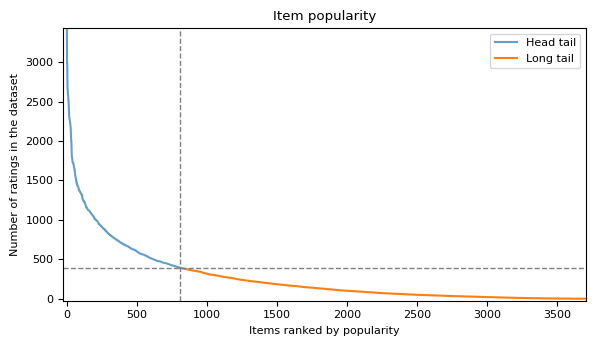

In [ ]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(6, 3.5))

plt.title(r'Item popularity')
plt.xlabel('Items ranked by popularity')
plt.ylabel('Number of ratings in the dataset')
plt.plot(range(head_tail_split), item_pop.values[:head_tail_split], alpha=0.7, label=r'Head tail')
plt.plot(range(head_tail_split, len(item_pop.index)), item_pop.values[head_tail_split:], label=r'Long tail')
plt.axhline(y=item_pop.values[head_tail_split], linestyle='--', lw=1, c='grey')
plt.axvline(x=head_tail_split, linestyle='--', lw=1, c='grey')
plt.xlim([-25, len(item_pop.index)])
plt.ylim([-25, item_pop.values[0]])
plt.legend()
plt.tight_layout()

Please note how the curve is skewed towards items with only few ratings. In our case, most popular items are those receving more than 450 ratings. In the rest of this study, we will investigate how recommendation algorithms treat items belonging to these sets.

## Data analysis: popularity of the recommended items

We will use the same cutoffs we have configured in the first notebook.

**IMPORTANT BOOKMARK** Please bookmark this point.

In [ ]:
cutoffs = np.array([5, 10, 20])

In [ ]:
model_types = ['utime_pairwise', 'utime_random', 'utime_mostpop']

To speed up, we will load the metrics pre-computed in the first notebook.

In [ ]:
metrics = {}
for model_type in model_types:
    metrics[model_type] = load_obj(os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + model_type + '_metrics.pkl'))

First, we will compare the considered algorithms based on their recommendation effectiveness: precision, recall, and NDCG.

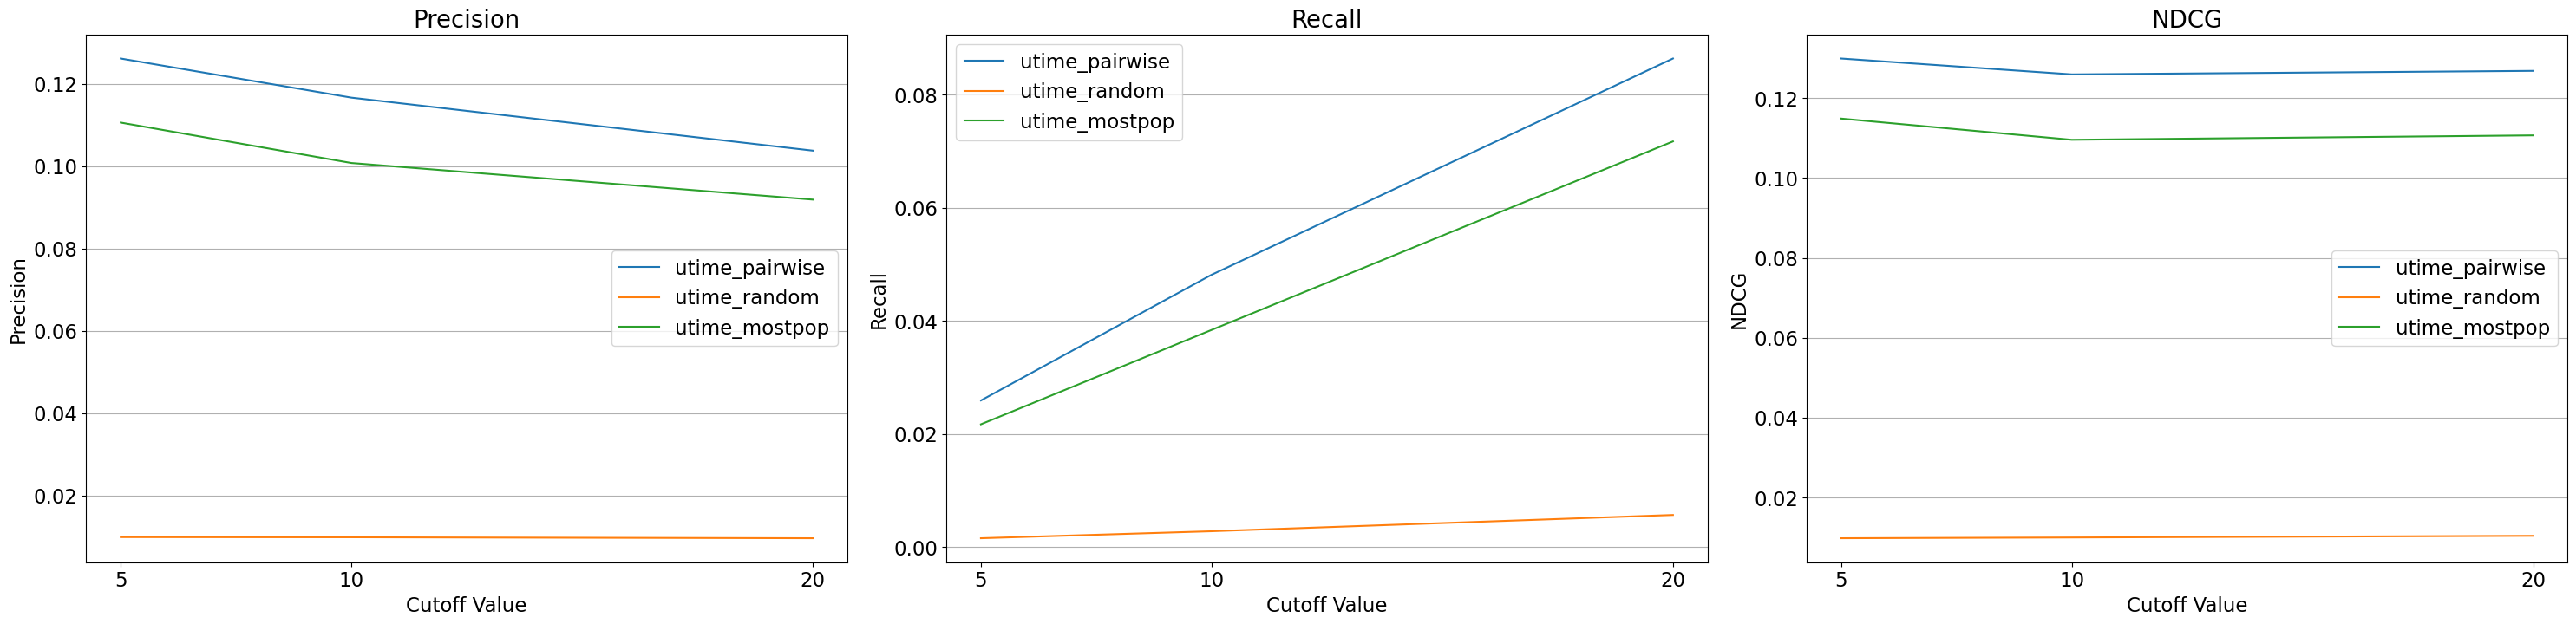

In [ ]:
plt.rcParams.update({'font.size': 16.5})
plt.figure(figsize=(30, 7.5))

plt.subplot(131)
plt.title(r'Precision')
plt.xlabel('Cutoff Value')
plt.ylabel('Precision')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['precision'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.xticks(cutoffs)
plt.legend()
plt.grid(axis='y')

plt.subplot(132)
plt.title(r'Recall')
plt.xlabel('Cutoff Value')
plt.ylabel('Recall')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['recall'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.xticks(cutoffs)
plt.legend()
plt.grid(axis='y')

plt.subplot(133)
plt.title(r'NDCG')
plt.xlabel('Cutoff Value')
plt.ylabel('NDCG')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['ndcg'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.xticks(cutoffs)
plt.legend()
plt.grid(axis='y')

plt.tight_layout()

Please note that pairwise and mostpop algorithms have a really similar behavior for all the considered metrics. Nove, we move our attention to the popularity of the recommended items and the coverage of the items we marked as "less popular".  

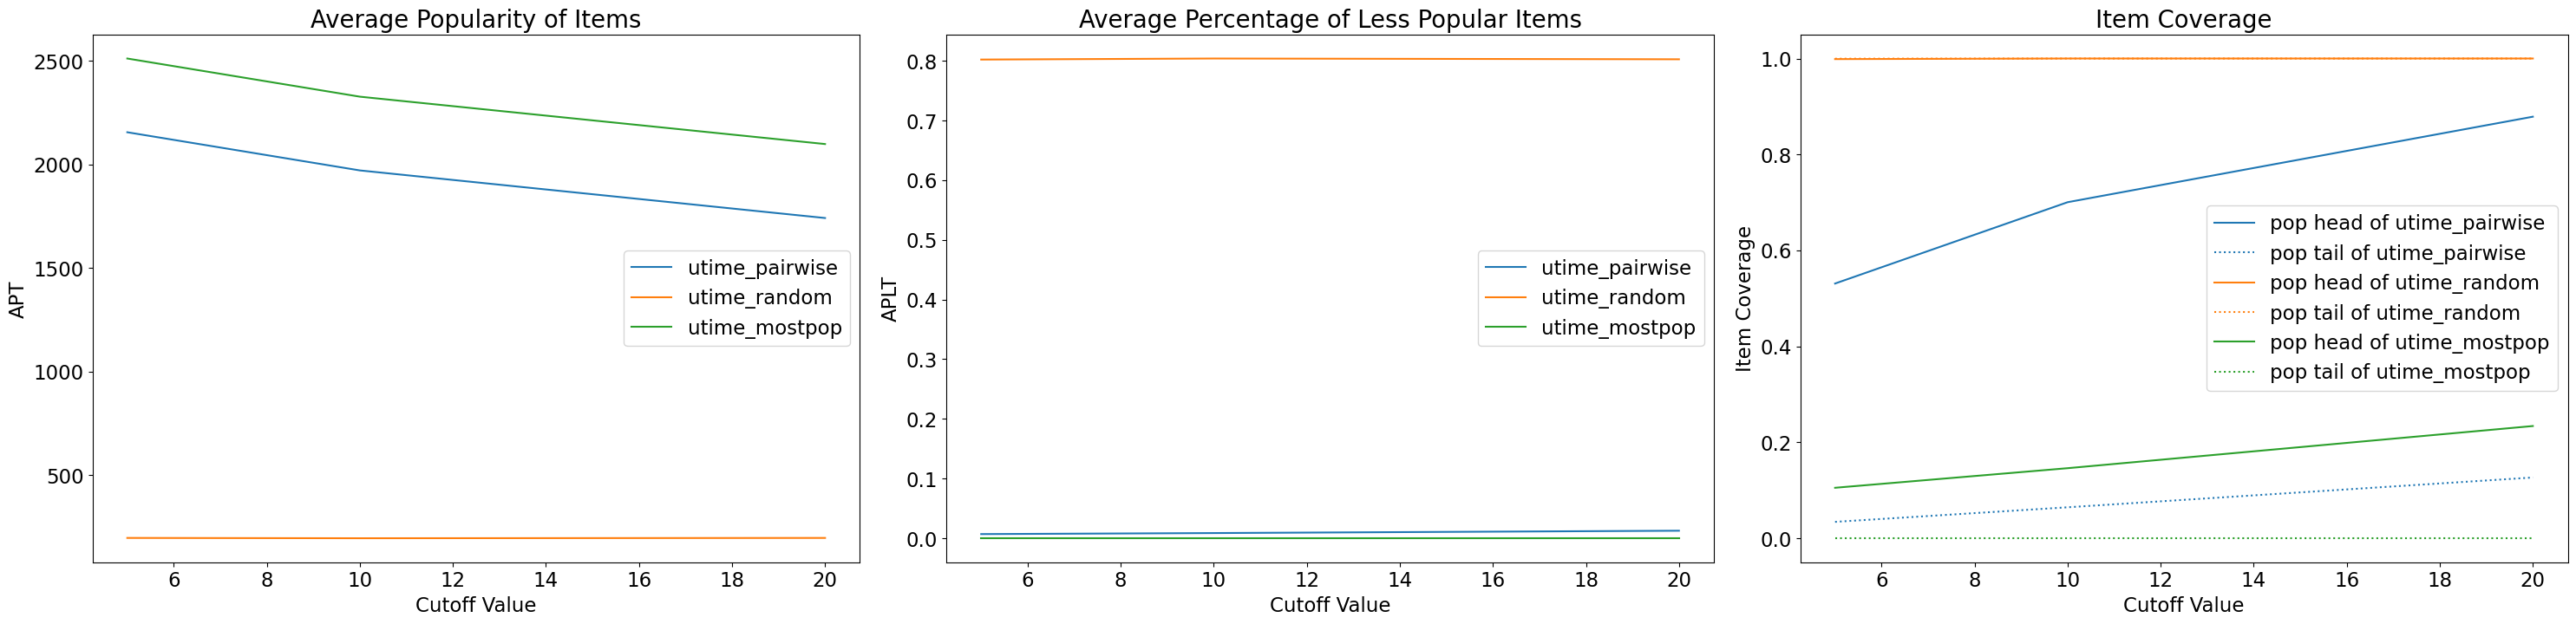

In [ ]:
plt.rcParams.update({'font.size': 16.5})
plt.figure(figsize=(30, 7.5))

plt.subplot(131)
plt.title(r'Average Popularity of Items')
plt.xlabel('Cutoff Value')
plt.ylabel('APT')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['mean_popularity'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.legend()

plt.subplot(132)
plt.title(r'Average Percentage of Less Popular Items')
plt.xlabel('Cutoff Value')
plt.ylabel('APLT')
for model_type in model_types:
    plt.plot(cutoffs, [np.sum(metrics[model_type]['item_coverage'][k,long_tail_items]) / np.sum(metrics[model_type]['item_coverage'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.legend()

plt.subplot(133)
plt.title(r'Item Coverage')
plt.xlabel('Cutoff Value')
plt.ylabel('Item Coverage')
for i, model_type in enumerate(model_types):
    plt.plot(cutoffs, [len([1 for m in metrics[model_type]['item_coverage'][k,head_tail_items] if m > 0]) / len(head_tail_items) for k in range(len(cutoffs))], color='C'+str(i), linestyle='-', label='pop head of ' + model_type)
    plt.plot(cutoffs, [len([1 for m in metrics[model_type]['item_coverage'][k,long_tail_items] if m > 0]) / len(long_tail_items) for k in range(len(cutoffs))], color='C'+str(i), linestyle=':', label='pop tail of ' + model_type)
plt.legend()

plt.tight_layout()

These figures show us that the average popularity of items recommended by the pairwise algorithm is really high and not so far from the one of items recommended by mostpop. This observation is also confirmed by the coverage of items from the "less popular" set. For small cutoffs, pairwise and mostpop recommened only a tiny fraction of the less popular items.

## Sample treatment to promote less popular items: post-processing

In this part, we will show how to setup and perform a post-processing mitigation approach. We show a didactic version of the xQuad algorithm adaptation proposed by Adbollahpouri et al. (2018). A model able to perform a re-ranking of the items has the same structure of the models we considered so far. Therefore, we first need to prepare all the data needed to initialize a model, as done in the first notebook.

In [ ]:
traintest = pd.read_csv('../data/outputs/splits/' + dataset + '_' + smode + '.csv', encoding='utf8')

In [ ]:
train = traintest[traintest['set']=='train'].copy()
test = traintest[traintest['set']=='test'].copy()

In [ ]:
users = list(np.unique(traintest[user_field].values))
items = list(np.unique(traintest[item_field].values))

In [ ]:
items_metadata = traintest.drop_duplicates(subset=['item_id'], keep='first')
category_per_item = items_metadata[type_field].values

Now, we are ready to import and usethe re-ranking model mentioned above.

In [ ]:
from models.ranker_xquad import RankerXQuad
model = RankerXQuad(users, items, train, test, category_per_item, item_field, user_field, rating_field)

Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics


In [ ]:
original_model_type = 'utime_pairwise' # This string identifies the recommendation algorithm where the re-ranking is applied
reranked_model_type = original_model_type + '_' + 'xquad' # This string is an identifier for models results in data/outputs

We initialize the model predictions with those of the original recommendation model, precomputed in the first notebook.

In [ ]:
predictions = load_obj(os.path.join(data_path,'outputs/predictions/' + dataset + '_' + original_model_type + '_scores.pkl'))

In [ ]:
model.set_predictions(predictions)

Now, we can run the re-ranking process and save the positional relevance of items for users after re-ranking.  

In [ ]:
model.rerank(type='smooth', lmbda=0.4, k=10, rmax=100, head_tail_split=head_tail_split)

In [ ]:
predictions = model.get_predictions()

In [ ]:
save_obj(predictions, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + reranked_model_type + '_scores.pkl'))

Finally, we compute and show the metrics for the recommender systems obtained after re-ranking.

In [ ]:
model.test(cutoffs)

In [ ]:
metrics = model.get_metrics()

In [ ]:
save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + reranked_model_type + '_metrics.h5'))

**To speed up**

This re-ranking takes several minutes. For this tutorial, please feel free to stop and load directly our pre-computed re-ranking predictions (2 MB).  

In [ ]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1lAmSPd19F4WRfWz0TOdFcOzHUMieSJOX'})
downloaded.GetContentFile('../data/outputs/metrics/ml1m_utime_pairwise_xquad_metrics.pkl')

In [ ]:
model.set_metrics(load_obj('../data/outputs/metrics/ml1m_utime_pairwise_xquad_metrics.pkl'))

In [ ]:
model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

Precision: 0.1029 
Recall: 0.0491 
NDCG: 0.1167 
Hit Rate: 0.5207 
Avg Popularity: 1156.0285 
Category Diversity: 0.3287 
Novelty: 2.9771 
Item Coverage: 0.39 
User Coverage: 0.5207


Finally, we have obtained the metrics resulting from the considered strategy. Now, we come back to the **IMPORTANT BOOKMARK** mention ed above, using cutoffs = np.array([5, 10]) and adding 'utime_pairwise_xquad' to the model_types list. Then, we can rerun all the cells for plotting in order to compare the results obtained with these strategy against the ones of the baseline recommendation algorithms.